In [4]:
# All imports 
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MultiLabelBinarizer, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import pickle

Los Angeles Crime 2020 - Present
===================
This dataset reflects incidents of crime in the City of Los Angeles dating back to 2020. This data is transcribed from original crime reports that are typed on paper and therefore there may be some inaccuracies within the data.
 
**`Acknowledgements:`**
 
Project idea from https://www.kaggle.com/datasets/chaitanyakck/crime-data-from-2020-to-present?select=Crime_Data_from_2020_to_Present.csv
 
Data Collection Source: https://data.lacity.org/Public-Safety/Crime-Data-from-2020-to-Present/2nrs-mtv8
 
**`Project Goal`**
------------
Categorize the neighborhoods of Los Angeles by crime severity to know and predict which areas/municipalities are categorized as dangerous according to the FBI’s Uniform Crime Reporting (UCR) Program. Crime comparison amongst areas references the California crime levels
 
1. "Violent Crime is composed of four offenses: murder and nonnegligent manslaughter, forcible rape, robbery, and aggravated assault. Violent crimes are defined in the UCR Program as those offenses which involve force or threat of force." ("Crime in the United States")
    * 428 per 100,000 residents (Lofstrom and Martin)
 
2. "Property crime includes the offenses of burglary, larceny-theft, motor vehicle theft, and arson." ("Crime in the United States")
    * 2,071 per 100,000 residents (Lofstrom and Martin)
 
*More information can be found at https://www.fbi.gov/services/cjis/ucr*

`References`

* Lofstrom and Martin. "Crime Trends in California." PPIC.org. Public Policy Institute of California. January 2022. https://www.ppic.org/publication/crime-trends-in-california/

* "2019 Crime in the United States." fbi.gov. Federal Bureau of Investigation. 2019. https://ucr.fbi.gov/crime-in-the-u.s/2019/crime-in-the-u.s.-2019
  
`Client Story:` A Los Angeles-based realtor wants to know which areas of Los Angeles to invest in (buy real estate). Since safety is a major concern for potential customers, the real estate agency wants to know the safest municipalities in the city to do business in. Thus, the real estate agency prefers to avoid areas of Los Angeles that may be risky to do business in. This ensures that the real estate investment is worthwhile in the long run and experience net gains. Areas with higher crime may scare away customers which could lead to a net loss of the investment. Market real estate price is not an issue to be wary of, the real estate agency solely wants to focus on the crime levels of the municipalities within the city.


Frame the Problem and Look at the Big Picture
=====================================
 
1. **Define the objective in business terms:**
Our client (the realtor based in Los Angeles), wants to know which areas of LA to invest in, based on the crime reports. Areas with higher crime rate and other determining factors are to be avoided, and areas with safer rates are much preferred.
 
2. **How will your solution be used?**
Our solution will be used in order to determine which areas of LA are the safest to invest into real-estate in that area. The results will not be a defined yes/no to invest in this area. The results will be used to assist the real estate agency into making their investment decision, potential crime is solely a factor of that decision. 

3. **What are current solutions (if any)?** Research crime data in the LA area. Results may vary, but there are plenty of research papers and other resources that study the crime levels of the city of Los Angeles. Sufficient research may indicate the areas of the city that face the most crime and ultimately affect the real estate market in an area.
 
4. **How should you frame this problem?** The problem is an unsupervised clustering problem since There isn't a label we can predict on. The clustering part comes in when having to separate the types of crimes, and we choose to define the threshold of what would be categorized as "dangerous." Furthermore, this problem is an offline learning system as identifying crime in an area is better suited to analyze over a period of time. Thus, we don't need to continuously update the program even though crime occurs very frequently. Important to also note that the data is updated weekly by the LAPD.
 
5. **How should performance be measured? Is the performance measure aligned with the business objective?**
Because we are working with an unsupervised problem that is going to be used with clustering. We will have to try a variety of different clustering algorithms. What clustering method we use will depend on the results outputted by silhouette, adjusted rand score of a variety of clustering methods. 
 
6. **What would be the minimum performance needed to reach the business objective?**
Minimum performance depends on the metric we end up using dependent on the clustering algorithm. Based off prior assignments though, we think a minimum of .4 will be a good score to test the goodness of our clusters. 
 
7. **What are comparable problems? Can you reuse experience or tools?** We can look at project two for reference on clustering and performing optimization. A couple of in class examples further demonstrated the use of clustering, dimensionality reduction. In addition, we could also look at some visualization work done from the California housing dataset (state being the same was not on purpose). Furthermore, reference to ensembles can be looked at from project 1 in addition to the potential to use neural networks which we can reference recent class examples.
 
8. **Is human expertise available?** There is no human expertise available. All the data is gathered from the LAPD
 
9. **How would you solve the problem manually?** Survey the populace of Los Angeles. The survey asks what they think of the crime status of their municipality. Asking multiple questions about different crimes, their reoccurrence and rate their municipality from a range of 1 to 10. 1 meaning very safe, 10 meaning very dangerous. The ending score for each surveyor would be the average of their ratings. All the surveys would then be combined and averaged out. The results of the survey would indicate which areas to avoid solely based off human interpretation
 
10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.** The data is provided from the LAPD. We assume that the information provided is as accurate and objective as possible. We assume no corruption, and misleading reporting by law enforcement and any office involved in the gathering, preparation, and sharing of the data.

In [5]:
class CrimeScore:
    """
    scorer function to use with GridSearchCV
    It is used like:

    GridSearchCV(..., scoring=MusicScorer(data), ...)

    where `data`is the full dataset from `load_data()`
    """

    def __init__(self, data, feature):
        self.feature = feature
        self.data = data

    def __call__(self, estimator, X, y=None):
        # Get the cluster labels
        if hasattr(estimator, 'labels_'):
            labels = estimator.labels_
        elif hasattr(estimator, 'predict'):
            labels = estimator.predict(X)
        else:
            labels = estimator.fit_predict(X)

        # Compute the score
        return crime_scorer(self.data, self.feature, labels)

def crime_scorer(data, feature, clusters):
    """
    Scores a set of clusters based on the crime data. The more crime in an area based off the severity of crimes commited, the higher the score

    lower crime codes = worse crime
        * 110 - 235
        * 237 - 436
        * 437 - 648
        * 649 - 756
        * 760 - 956
    """
    area_populations = {'Southwest' : 165000, 'Central'  : 40000, '77th Street' : 175000, 'N Hollywood' : 220000, 'Mission' : 225849, 'Southeast' : 150000,
        'Devonshire' : 219136, 'Harbor' : 171000, 'West Valley' : 196840, 'West LA' : 228000 , 'Pacific' : 200000,'Wilshire' : 500000 , 'Hollywood' : 300000, 
        'Northeast' : 250000, 'Hollenbeck' : 200000, 'Olympic'  : 282490, 'Newton' : 148992, 'Topanga' : 8560, 'Foothill' : 182214, 'Rampart' : 164961,
        'Van Nuys' : 325000}
    n_crimes = 0
    n_clusters = clusters.max()
    feature.value_counts()
    crime_codes = [data[feature]] # crime_codes becomes a list
    location_pop = 0
    # crime_rate = n_crimes/POPULATION * 100,000 crime rate formula determined by the state of california, Population should be from every area
    # not entire state
    for i in range(n_clusters):
        location = area_populations.get(clusters)
        n_crimes = 2
       # if (data[feature])
        
    return 0

def remove_outliers(X):
    """
    Removes Outliers from the data
    """
    return X

In [62]:
area_populations = {'Southwest' : 165000, 'Central'  : 40000, '77th Street' : 175000, 'N Hollywood' : 220000, 'Mission' : 225849, 'Southeast' : 150000,
        'Devonshire' : 219136, 'Harbor' : 171000, 'West Valley' : 196840, 'West LA' : 228000 , 'Pacific' : 200000,'Wilshire' : 500000 , 'Hollywood' : 300000, 
        'Northeast' : 250000, 'Hollenbeck' : 200000, 'Olympic'  : 282490, 'Newton' : 148992, 'Topanga' : 8560, 'Foothill' : 182214, 'Rampart' : 164961,
        'Van Nuys' : 325000}


AREA POPULATIONS

* population data from https://www.lapdonline.org/find-your-local-police-station/

`Southwest` - 165,000

`Central` - 40,000

`77th Street`- 175,000

`N Hollywood`- 220,000

`Mission`- 225,849

`Southeast`- 150,000

`Devonshire`- 219,136

`Harbor`- 171,000

`West Valley`- 196,840

`West LA`- 228,000 

`Pacific`- 200,000

`Wilshire`- 500,000 

`Hollywood`- 300,000 

`Northeast`- 250,000

`Hollenbeck`- 200,000

`Olympic` - 282,490 *not Available - averaged out from the districts directly bordering it instead* 

`Newton`- 148,992 *not Available - averaged out from the districts directly bordering it instead* 

`Topanga`- 8,560

`Foothill`- 182,214

`Rampart`- 164,961

`Van Nuys`- 325,000


Get The Data
==================

1. **List the data you need and how much you need:** BELOW

2. **Find and document where you can get that data:** Data collected from Los Angeles open data catalog. Link provided in the `Acknowledgements:` section of project description

3. **Get access authorizations:** None needed. Data is open for developer use

4. **Create a workspace (with enough storage space):** This notebook

5. **Get the data:** BELOW

6. **Convert the data to a format you can easily manipulate (without changing the data itself):** data provided as CSV files.

7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** Done

8. **Check the size and type of data (time series, geographical, ...):** report of data available at the end of this section in markdown cell titled "summary"

In [53]:
# Read the data from the CSV File
data = pd.read_csv('Crime_Data_from_2020_to_Present.csv')

In [5]:
# A quick view of the features and samples
data

,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,10304468,01/08/2020 12:00:00 AM,01/08/2020 12:00:00 AM,2230,3,Southwest,377,2,624,BATTERY - SIMPLE ASSAULT,...,AO,Adult Other,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.0141,-118.2978
1,190101086,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,330,1,Central,163,2,624,BATTERY - SIMPLE ASSAULT,...,IC,Invest Cont,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.0459,-118.2545
2,191501505,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,1730,15,N Hollywood,1543,2,745,VANDALISM - MISDEAMEANOR ($399 OR UNDER),...,IC,Invest Cont,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.1685,-118.4019
3,191921269,01/01/2020 12:00:00 AM,01/01/2020 12:00:00 AM,415,19,Mission,1998,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,IC,Invest Cont,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.2198,-118.4468
4,200100501,01/02/2020 12:00:00 AM,01/01/2020 12:00:00 AM,30,1,Central,163,1,121,"RAPE, FORCIBLE",...,IC,Invest Cont,121.0,998.0,NaN,NaN,700 S BROADWAY,NaN,34.0452,-118.2534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472423,221906145,02/23/2022 12:00:00 AM,02/23/2022 12:00:00 AM,1210,19,Mission,1985,1,421,THEFT FROM MOTOR VEHICLE - ATTEMPT,...,IC,Invest Cont,421.0,998.0,NaN,NaN,8400 VAN NUYS BL,NaN,34.2229,-118.4487
472424,221108224,04/23/2022 12:00:00 AM,04/23/2022 12:00:00 AM,100,11,Northeast,1189,1,210,ROBBERY,...,IC,Invest Cont,210.0,NaN,NaN,NaN,3200 N FIGUEROA ST,NaN,34.0854,-118.2204
472425,221005507,02/10/2022 12:00:00 AM,02/09/2022 12:00:00 AM,1530,10,West Valley,1024,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,18800 SHERMAN WY,NaN,34.2011,-118.5426
472426,221105477,02/10/2022 12:00:00 AM,02/08/2022 12:00:00 AM,2000,11,Northeast,1171,1,510,VEHICLE - STOLEN,...,IC,Invest Cont,510.0,NaN,NaN,NaN,4000 FOUNTAIN AV,NaN,34.0958,-118.2787


In [6]:
# A further look into the features
data.describe()

,DR_NO,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Age,Premis Cd,Weapon Used Cd,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LAT,LON
count,4.724280e+05,472428.000000,472428.000000,472428.000000,472428.000000,472428.000000,472428.000000,472423.000000,168867.000000,472422.000000,36880.000000,1260.000000,36.000000,472428.000000,472428.000000
mean,2.085657e+08,1347.188361,10.771375,1123.420466,1.411345,505.133049,29.951889,298.742781,361.242765,504.860815,955.375515,982.004762,987.333333,33.909043,-117.783817
std,7.075535e+06,652.049400,6.064629,606.526807,0.492078,209.259073,21.716405,215.422721,124.193220,209.049712,115.292097,55.571319,34.766979,2.362985,8.199352
min,8.170000e+02,1.000000,1.000000,101.000000,1.000000,110.000000,-1.000000,101.000000,101.000000,110.000000,210.000000,434.000000,821.000000,0.000000,-118.667600
25%,2.013166e+08,908.000000,6.000000,628.000000,1.000000,330.000000,11.000000,101.000000,308.000000,330.000000,998.000000,998.000000,998.000000,34.010900,-118.430100
50%,2.105084e+08,1430.000000,11.000000,1145.000000,1.000000,480.000000,31.000000,203.000000,400.000000,480.000000,998.000000,998.000000,998.000000,34.058200,-118.322400
75%,2.117042e+08,1900.000000,16.000000,1621.000000,2.000000,626.000000,45.000000,501.000000,400.000000,626.000000,998.000000,998.000000,998.000000,34.163100,-118.274000
max,2.299104e+08,2359.000000,21.000000,2199.000000,2.000000,956.000000,120.000000,971.000000,516.000000,956.000000,999.000000,999.000000,999.000000,34.334300,0.000000


In [7]:
# Checking to see if there are missing values (There is in 18 features)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 472428 entries, 0 to 472427
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           472428 non-null  int64  
 1   Date Rptd       472428 non-null  object 
 2   DATE OCC        472428 non-null  object 
 3   TIME OCC        472428 non-null  int64  
 4   AREA            472428 non-null  int64  
 5   AREA NAME       472428 non-null  object 
 6   Rpt Dist No     472428 non-null  int64  
 7   Part 1-2        472428 non-null  int64  
 8   Crm Cd          472428 non-null  int64  
 9   Crm Cd Desc     472428 non-null  object 
 10  Mocodes         406588 non-null  object 
 11  Vict Age        472428 non-null  int64  
 12  Vict Sex        409290 non-null  object 
 13  Vict Descent    409284 non-null  object 
 14  Premis Cd       472423 non-null  float64
 15  Premis Desc     472226 non-null  object 
 16  Weapon Used Cd  168867 non-null  float64
 17  Weapon Des

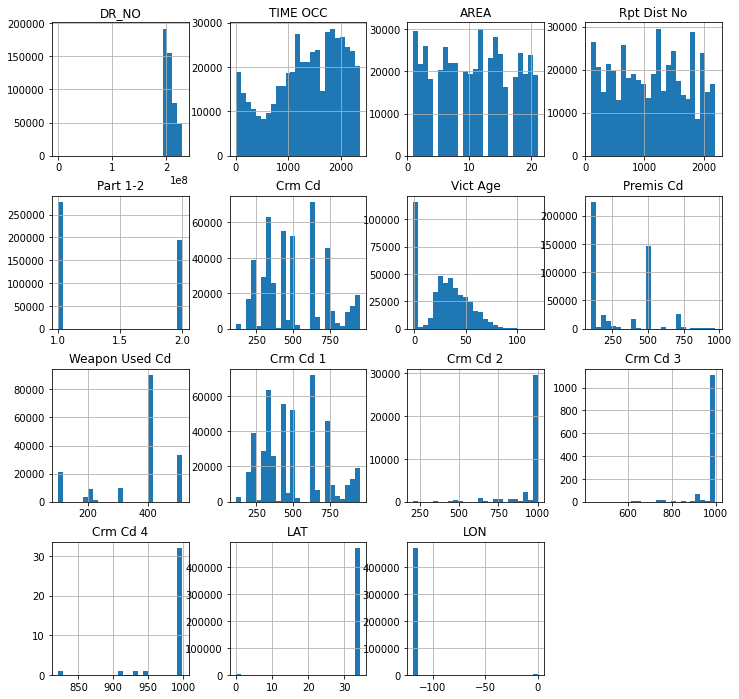

In [8]:
# Histogram of the data to see the distributions of features
data.hist(bins=25, figsize=(12, 12));


In [9]:
print(data['Vict Age'].value_counts()), print(data['Vict Age'].max())

 0      115323
 30      10854
 35      10447
 29      10373
 28      10283
         ...  
 96         43
 98         38
 97         31
-1          12
 120         1
Name: Vict Age, Length: 101, dtype: int64
120


(None, None)

In [10]:
data['Date Rptd'].value_counts()

04/04/2022 12:00:00 AM    876
03/21/2022 12:00:00 AM    791
03/01/2022 12:00:00 AM    768
11/01/2021 12:00:00 AM    753
10/12/2021 12:00:00 AM    742
                         ... 
03/21/2020 12:00:00 AM    383
04/05/2020 12:00:00 AM    363
03/29/2020 12:00:00 AM    353
01/01/2020 12:00:00 AM    353
03/22/2020 12:00:00 AM    349
Name: Date Rptd, Length: 846, dtype: int64

In [11]:
pd.to_datetime(data['Date Rptd']).sort_values

<bound method Series.sort_values of 0        2020-01-08
1        2020-01-02
2        2020-01-01
3        2020-01-01
4        2020-01-02
            ...    
472423   2022-02-23
472424   2022-04-23
472425   2022-02-10
472426   2022-02-10
472427   2022-02-15
Name: Date Rptd, Length: 472428, dtype: datetime64[ns]>

Summary 
----------
1. There are 463371 samples of data

2. There are 28 features in the dataset

3. There is a lot of missing values from a couple of features in the data. These include: 
    * `Mocodes`, `Vict Sex`, `Vict Descent`, `Premis Cd`, `Premis Desc`, `Weapon Used Cd`, `Weapon Desc`, `Cross Street`

4. `Crm Cd 1` seems to only be missing 2 samples.  `Crm Cd 2`, `Crm Cd 3`, and `Crm Cd 4` have missing values because these only get added to if there are additional crimes to add

5. Through the initial analyzation of the data, we figured that there are a couple features that can be dropped. `Part 1-2` seems to provide us nothing in terms of what it provides. The description from where the data was gathered was empty, so we have even less idea of what it implies. `Dr No` also looks like it can be dropped. The other features look pretty important

6. What sick person committed a crime against a 120-year-old

7. `Date Rptd` and `DATE OCC` are awkward features since they also include a time along with the data the crime occurred. The time part of these features are always set to '12:00:00 AM'. What makes this part useless is that the feature `TIME OCC` exists which provides what time the crime occurred. With that discovery, we can manipulate the data by simply extracting the date from `Date Rptd` and `DATE OCC` and ignoring the '12:00:00 AM' part of these features.


Explore The Data
-------

In [34]:
# Copy of the data we can freshly explore on
copy = data.copy()

In [35]:
copy.columns

Index(['DR_NO', 'Date Rptd', 'DATE OCC', 'TIME OCC', 'AREA', 'AREA NAME',
       'Rpt Dist No', 'Part 1-2', 'Crm Cd', 'Crm Cd Desc', 'Mocodes',
       'Vict Age', 'Vict Sex', 'Vict Descent', 'Premis Cd', 'Premis Desc',
       'Weapon Used Cd', 'Weapon Desc', 'Status', 'Status Desc', 'Crm Cd 1',
       'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'LOCATION', 'Cross Street', 'LAT',
       'LON'],
      dtype='object')

In [36]:
copy["Crm Cd 4"].value_counts()

998.0    31
930.0     1
821.0     1
910.0     1
999.0     1
946.0     1
Name: Crm Cd 4, dtype: int64

In [37]:
# Drop 'DR_NO' and 'Part 1-2' featues from copy dataset. Crm cd 4 has 36 samples so its negligable. 
# TODO, maybe Crm Cd 3?
copy.drop('DR_NO', inplace=True, axis=1)
copy.drop('Part 1-2', inplace=True, axis=1)
copy.drop("Crm Cd 4", inplace=True, axis=1)
copy.drop("Date Rptd", inplace=True, axis=1)


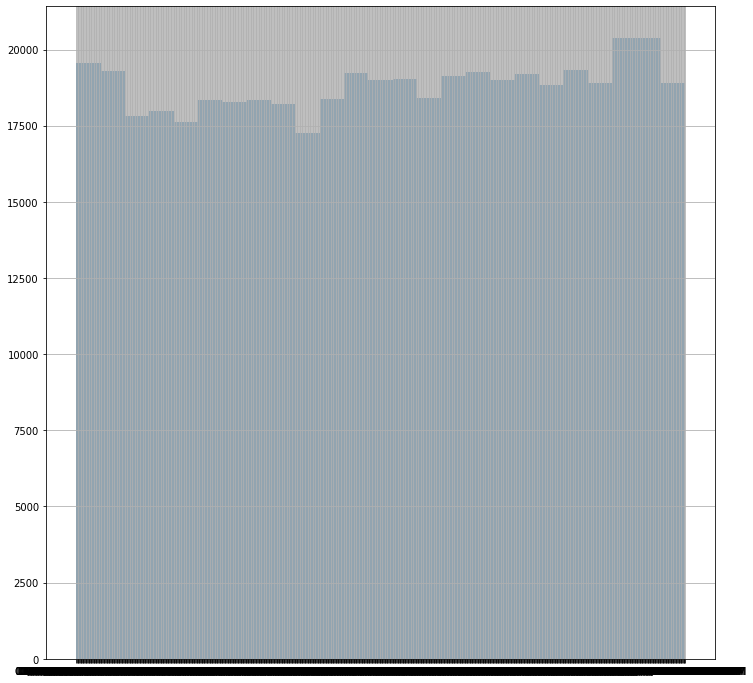

In [38]:
# View if there are any changes over crime occurenence over time. 
copy["DATE OCC"].hist(bins=25, figsize=(12, 12));

In [39]:
copy.drop("DATE OCC", inplace=True, axis=1)

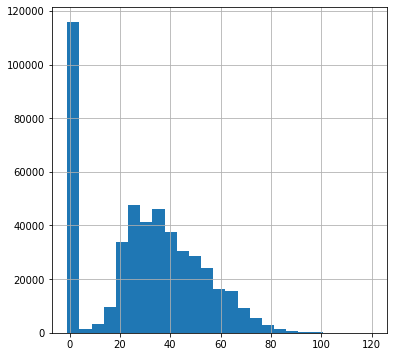

In [19]:
# will have to replace values of 0 with the mean
copy['Vict Age'].hist(bins=25, figsize=(6, 6));

In [40]:
# replace vict age 
copy["Vict Age"].replace(to_replace = 0, value = copy["Vict Age"].mean(), inplace=True)


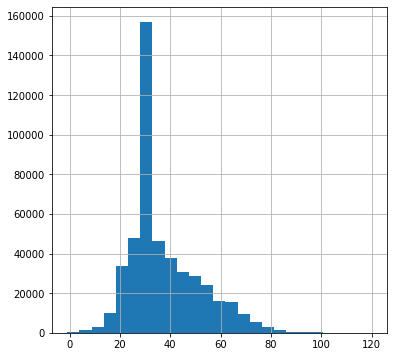

In [21]:
# will have to replace values of 0 with the mean
copy['Vict Age'].hist(bins=25, figsize=(6, 6));

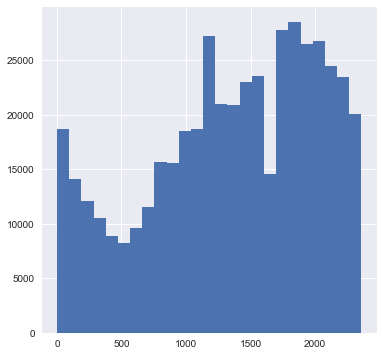

In [96]:
# normally distributed but cut off becuase of daily time contraints
copy['TIME OCC'].hist(bins=25, figsize=(6, 6));

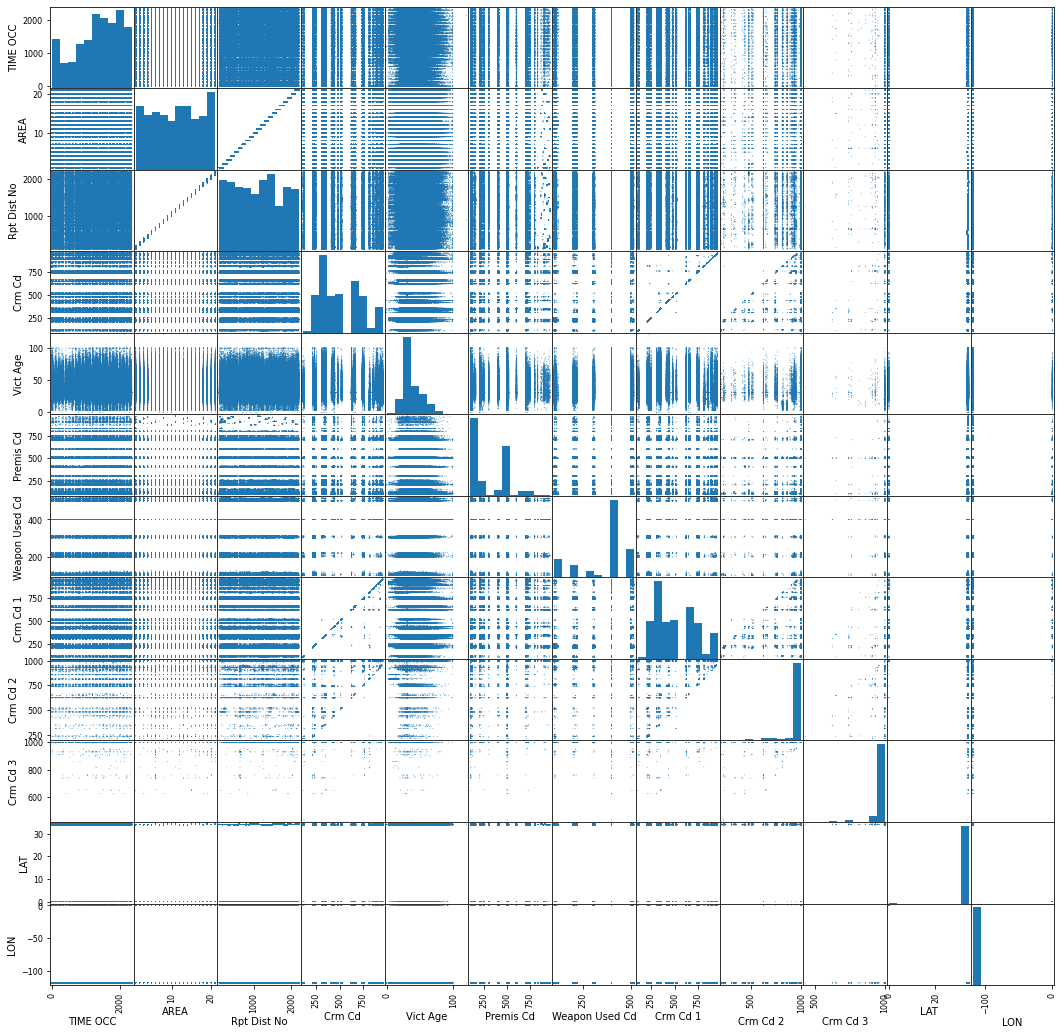

In [23]:
# don't overwhelm poor little human brains. Attempt to see any correlations among the data dataset
pd.plotting.scatter_matrix(copy, figsize=(18, 18), s=3, alpha=0.8);

<AxesSubplot:>

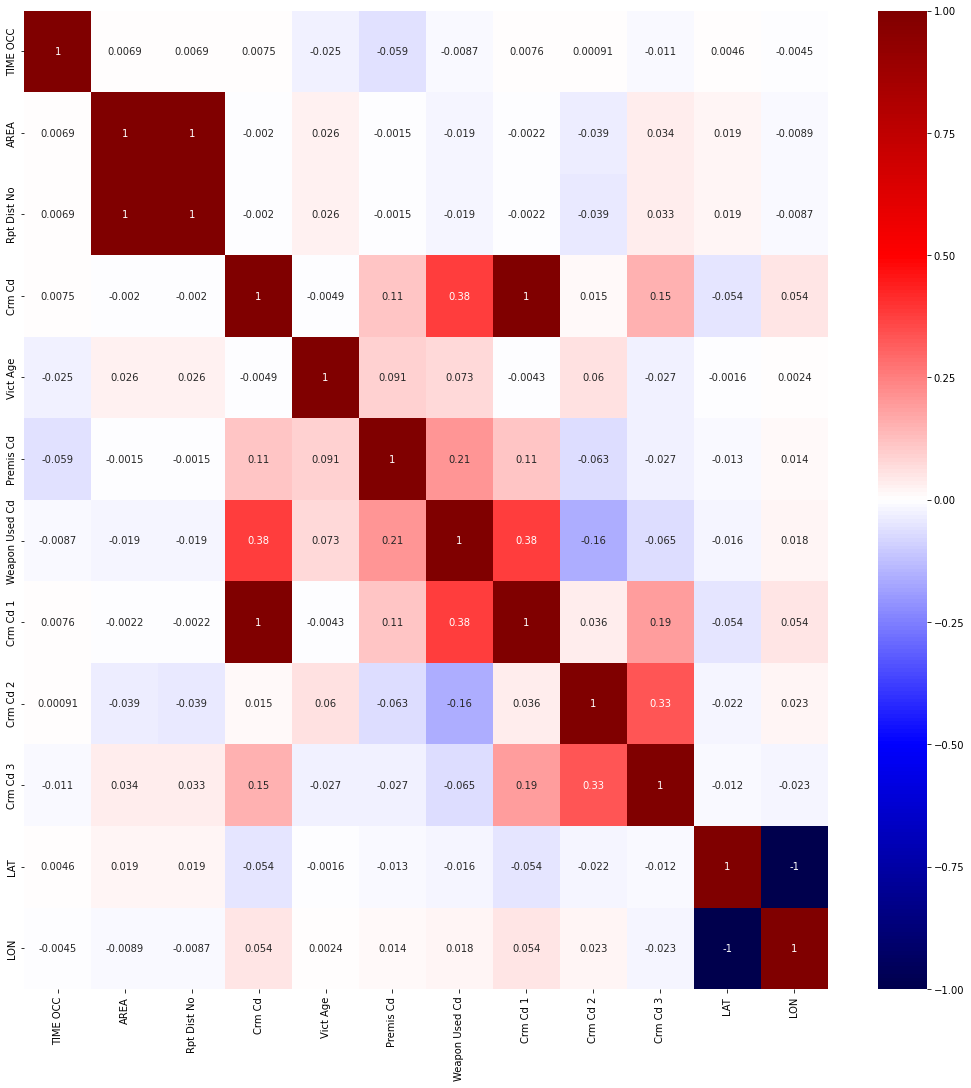

In [24]:
# view the linear correlations of the dataset
plt.figure(figsize=(18, 18))
sns.heatmap(copy.corr(), annot=True, vmin=-1, vmax=1, cmap='seismic')

In [25]:
# LON has 0 values. 
copy.LON.value_counts()

-118.2739    3438
-118.2827    3048
 0.0000      2278
-118.2652    1961
-118.2783    1932
             ... 
-118.5692       1
-118.6556       1
-118.6163       1
-118.6360       1
-118.6613       1
Name: LON, Length: 4930, dtype: int64

In [26]:
# LAT has 0 values. 
copy.LAT.value_counts()

34.1016    2655
0.0000     2278
34.0980    2192
34.2012    2132
34.1939    1645
           ... 
33.8108       1
33.7646       1
33.7076       1
33.8750       1
33.8589       1
Name: LAT, Length: 5298, dtype: int64

In [42]:
# current solution: Alter LAT and LON rows with 0 values to nans- TODO
# copy = copy[copy.LAT != 0]
# copy = copy[copy.LON != 0]

# Convert 0 values in LAT and LON to nan . . . I think this could be missing things up
copy.loc[copy["LAT"] == 0.0000] = np.nan
copy.loc[copy["LON"] == 0.0000] = np.nan

In [28]:
# verify 0 values converted to nan
copy.LAT.isnull().value_counts()

False    470150
True       2278
Name: LAT, dtype: int64

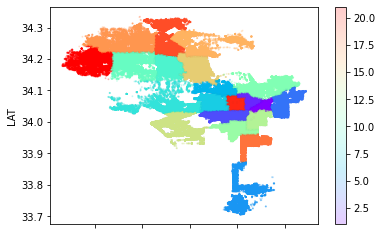

In [43]:
# view geographical data by plotting the latitude and longitude. Los Angeles has a horrible layout. 
# Displays the 21 police districts
copy.plot(kind="scatter", x="LON", y="LAT", alpha=0.2,  s=1, c=data["AREA"], cmap='rainbow');

In [30]:
# what the hell is h, data catalog does not specify. 
copy['Vict Sex'].value_counts()

M    197840
F    171445
X     37762
H        52
Name: Vict Sex, dtype: int64

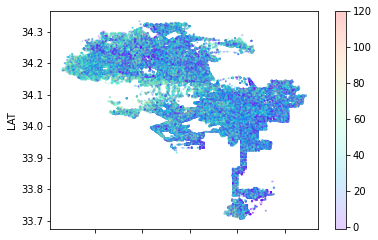

In [31]:
# maybe will get better visuals after removing outliers
copy.plot(kind="scatter", x="LON", y="LAT", alpha=0.2,  s=1, c=data["Vict Age"], cmap='rainbow');

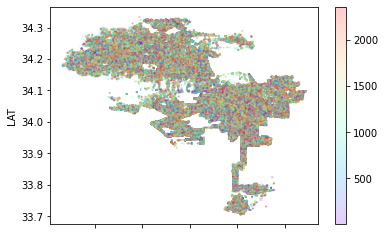

In [32]:
# is there areas where certain times of day incur more crimes? . . . doesn't look like it
copy.plot(kind="scatter", x="LON", y="LAT", alpha=0.2,  s=1, c=data["TIME OCC"], cmap='rainbow');


In [33]:
print(copy["Premis Cd"].max())
print(copy["Premis Cd"].min())
print(copy["Premis Cd"].mean())
print(copy["Premis Cd"].median())

971.0
101.0
298.5227323485308
203.0


In [34]:
copy['Premis Cd'].isnull().value_counts()


False    470145
True       2283
Name: Premis Cd, dtype: int64

In [35]:
print(copy["Weapon Used Cd"].max())
print(copy["Weapon Used Cd"].min())
print(copy["Weapon Used Cd"].mean())
print(copy["Weapon Used Cd"].median())

516.0
101.0
361.0766722014914
400.0


In [36]:
copy['Vict Sex'].value_counts()

M    197840
F    171445
X     37762
H        52
Name: Vict Sex, dtype: int64

In [37]:
le = LabelEncoder()
label = le.fit_transform(copy['Vict Sex'])
copy["Vict Sex"] = label
 
# printing Dataframe
copy["Vict Sex"].value_counts()

2    197840
0    171445
4     65329
3     37762
1        52
Name: Vict Sex, dtype: int64

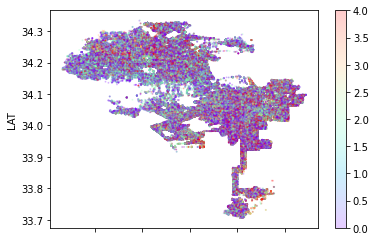

In [38]:
copy.plot(kind="scatter", x="LON", y="LAT", alpha=0.2,  s=1, c=copy["Vict Sex"], cmap='rainbow');

In [39]:
le = LabelEncoder()
label = le.fit_transform(copy['LOCATION'])
copy["LOCATION"] = label
 
# printing Dataframe
copy["LOCATION"].value_counts()

55912    2278
44196     896
43806     808
40599     805
43809     805
         ... 
13246       1
24089       1
12180       1
54263       1
29956       1
Name: LOCATION, Length: 55913, dtype: int64

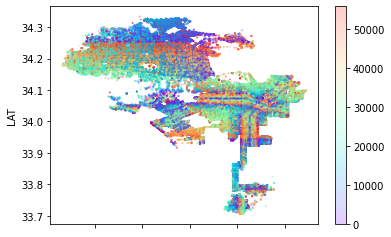

In [40]:
# looks like something
copy.plot(kind="scatter", x="LON", y="LAT", alpha=0.2,  s=1, c=copy["LOCATION"], cmap='rainbow');

In [23]:
le = LabelEncoder()
label = le.fit_transform(copy['AREA NAME'])
copy["AREA NAME"] = label
 
# printing Dataframe
copy["AREA NAME"].value_counts()

0     29993
1     29341
12    28033
15    25975
6     25385
14    24173
8     23994
11    23675
9     23022
18    22006
20    21877
13    21582
10    20506
4     20228
17    19921
19    19253
7     19248
16    19065
2     18665
5     18046
3     16162
21     2278
Name: AREA NAME, dtype: int64

In [ ]:
# looks like something
copy.plot(kind="scatter", x="LON", y="LAT", alpha=0.2,  s=1, c=copy["AREA NAME"], cmap='rainbow');

<AxesSubplot:>

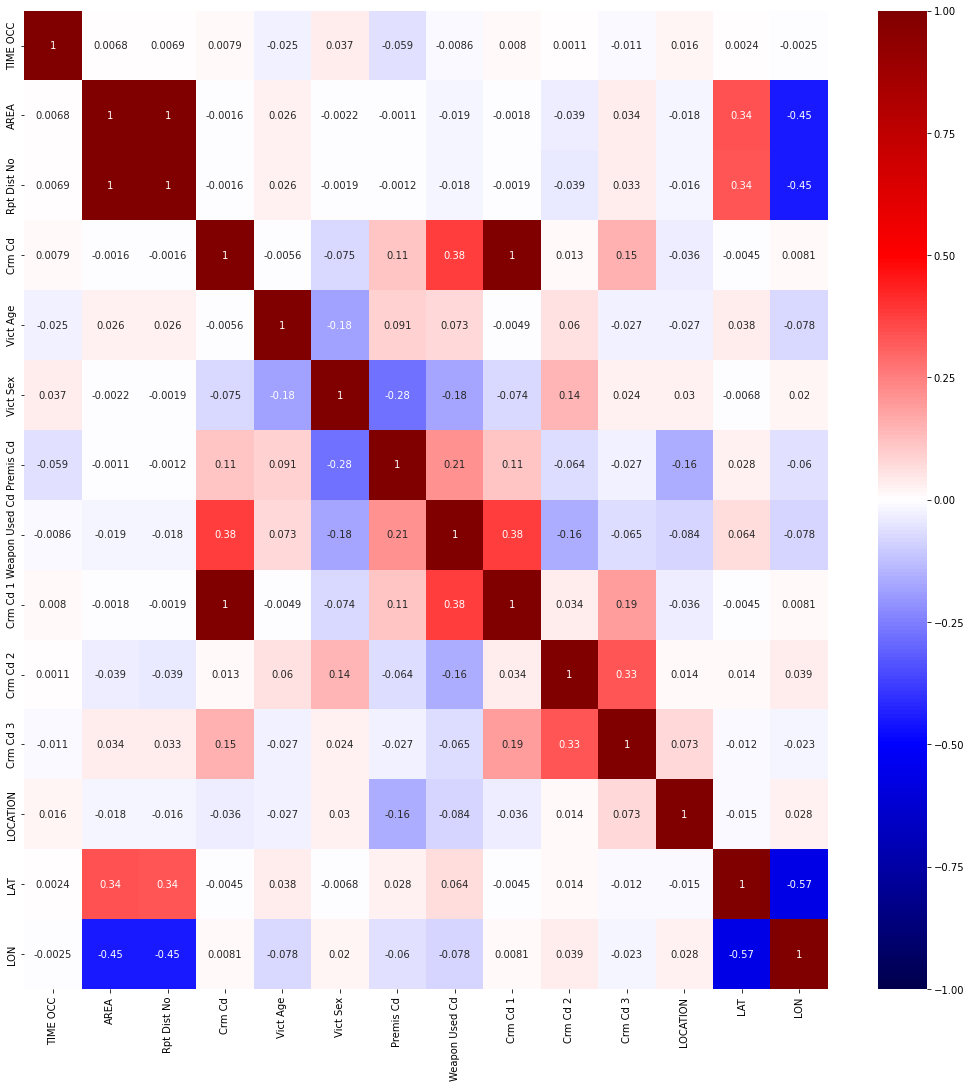

In [41]:
# view the linear correlations of the dataset
plt.figure(figsize=(18, 18))
sns.heatmap(copy.corr(), annot=True, vmin=-1, vmax=1, cmap='seismic')

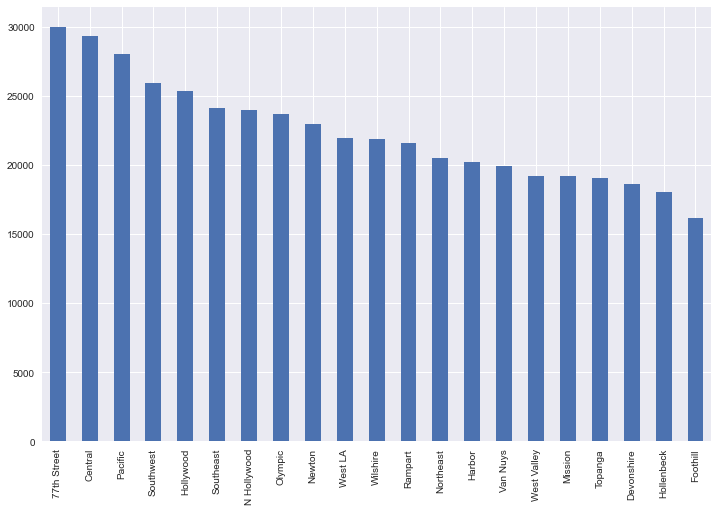

In [95]:
color=plt.cm.ocean(np.linspace(0,2,5))
copy["AREA NAME"].value_counts().plot.bar(figsize=(12,8))
plt.show()

Summary 
==========
1. Copy the data for exploration, down sampling to a manageable size if necessary. 
    
2. Study each attribute and its characteristics: Name; Type (categorical, numerical, 
bounded, text, structured, ...); % of missing values; Noisiness and type of noise (stochastic, outliers, rounding errors, ...); 
Usefulness for the task; Type of distribution (Gaussian, uniform, logarithmic, ...) 
 
   * 13 Categorical Features
   
      * *`Date Rptd`* - Date reported
   
      * *`DATE OCC`* - Date occurred
   
      * *`AREA NAME`* - The 21 Geographic Areas or Patrol Divisions are also given a name designation that references a landmark or the surrounding community that it is responsible for. For example, 77th Street Division is located at the intersection of South Broadway and 77th Street, serving neighborhoods in South Los Angeles
   
      * *`Crm Cd Desc`* - Defines the Crime Code provided
   
      * *`Mocodes`* - Modus Operandi: Activities associated with the suspect in commission of the crime
   
      * *`Vict Sex`* - F - Female M - Male X - Unknown
   
      * *`Vict Descent`* - Descent Code: A - Other Asian B - Black C - Chinese D - Cambodian F - Filipino G - Guamanian H - Hispanic/Latin/Mexican I - American Indian/Alaskan Native J - Japanese K - Korean L - Laotian O - Other P - Pacific Islander S - Samoan U - Hawaiian V - Vietnamese W - White X - Unknown Z - Asian Indian
   
      * *`Premis Desc`* - Defines the Premise Code provided
   
      * *`Weapon Desc`* - Defines the Weapon Used Code provided
   
      * *`Status`* - Status of the case. (IC is the default)
   
      * *`Status Desc`* - Defines the Status Code provided
   
      * *`LOCATION`* - Street address of crime incident rounded to the nearest a hundred block to maintain anonymity
   
      * *`Cross Street`* - Cross Street of rounded Address
 
 
   * 15 Numerical Features
   
      * *`DR_NO`* - Division of Records Number: Official file number made up of a 2 digit year, area ID, and 5 digits
   
      * *`Part 1-2`* - Not Defined from the data descriptions of the data provided
   
      * *`TIME OCC`* - Time occurred in 24 hours military time
   
      * *`AREA`* - The LAPD has 21 Community Police Stations referred to as Geographic Areas within the department. These Geographic Areas are sequentially numbered from 1-21
   
      * *`Rpt Dist No`* - A four-digit code that represents a sub-area within a Geographic Area. All crime records reference the "RD" that it occurred in for statistical comparisons
   
      * *`Crm Cd`* - Indicates the crime committed. (Same as Crime Code 1)
   
      * *`Vict Age`* - Two character numeric of the victims age
   
      * *`Premis Cd`* - The type of structure, vehicle, or location where the crime took place
   
      * *`Weapon Used Cd`* - The type of weapon used in the crime
   
      * *`Crm Cd 1`* - Indicates the crime committed. Crime Code 1 is the primary and most serious one. Crime Code 2, 3, and 4 are respectively less serious offenses. Lower crime class numbers are more serious
   
      * *`Crm Cd 2`* - May contain a code for an additional crime, less serious than Crime Code 1
   
      * *`Crm Cd 3`* - May contain a code for an additional crime, less serious than Crime Code 2
   
      * *`Crm Cd 4`* - May contain a code for an additional crime, less serious than Crime Code 3
   
      * *`LAT`* - Latitude
   
      * *`LON`* - Longitude



5. Study the correlations between attributes 

7. Identify the promising transformations you may want to apply 

 `LAT` and `LON` have 0's as values. Changed those to Nan's to be able to visualize with other features

 There is a minimal dip of crime between January 2020 to the first half of 2021. This could be due to Covid-19 and the lockdown 
 procedures that occurred in the state of California. 



Prepare the Data
-----------

In [7]:
# Custom Transformers to use within a pipeline

class NumpyArrayToPandasDataFrame(BaseEstimator, TransformerMixin):
   """
   This class takes a numpy array as well as a list of indexes and column names to transform
   a numpy array back into a pandas dataframe during within a pipeline.
   """
   def __init__(self, transformer):
       super().__init__()
       self.transformer = transformer
      
   def fit(self, X, y=None):
       self.transformer.fit(X, y)
       return self
  
   def transform(self, X):
       X_new = self.transformer.transform(X)
       if not isinstance(X_new, pd.DataFrame):   
           self.indexes_ = X.index
           self.columns_ = X.columns
           return pd.DataFrame(X_new, index=self.indexes_[:X.shape[0]], columns=self.columns_[:X.shape[1]])
       return X_new

class AddHoursTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to be used within a pipeline. Will add 2400 to a datetime feature sample between the range 0-400.
    """
    def __init__(self):
        super().__init__()

    def fit(self, X, y=None, **kwargs):
        # This transformer has nothing to learn from the training data
        return self

    def transform(self, X):
        X[(0 <= X) & (X < 5)] +=2400
        return X 

class convert_0_values_to_mean(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, feature):
        self.feature = feature
        super().__init__()

    def fit(self, X, y=None, **kwargs):
        # This transformer has nothing to learn from the training data
        return self

    def transform(self, X):
        X[self.feature].replace(to_replace = 0, value = copy[self.feature].mean(), inplace=True)
        return X 

class convert_values_to_nan_Transformer(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, feature1, feature2):
        self.feature1 = feature1
        self.feature2 = feature2
        super().__init__()

    def fit(self, X, y=None, **kwargs):
        # This transformer has nothing to learn from the training data
        return self

    def transform(self, X):
        X.loc[X[self.feature1] == 0.0000] = np.nan
        X.loc[X[self.feature2] == 0.0000] = np.nan

        return X 

class timestamp_removal_Transformer(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, feature):
        self.feature = feature
        super().__init__()

    def fit(self, X, y=None, **kwargs):
        # This transformer has nothing to learn from the training data
        return self

    def transform(self, X):
        X[self.feature] = pd.to_datetime(X[self.feature])
        return X 


In [8]:
attrs = ['TIME OCC', 'AREA', 'Rpt Dist No', 'Crm Cd', 'Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3' ,'Premis Cd', 'Vict Age', 'LAT', 'LON']

In [9]:
#'DATE OCC' 'Mocodes'
categorical = ['AREA NAME', 'Vict Sex', 'Vict Descent', 'Premis Desc', 'Weapon Desc']

In [10]:
data["LOCATION"].value_counts()

800 N  ALAMEDA                      ST      912
7TH                                         813
7TH                          ST             810
6TH                          ST             808
6TH                                         746
                                           ... 
10200    NOBLE                        AV      1
2300    CRESTON                      DR       1
8200    JELLICO                      AV       1
800    MAIN                         ST        1
400    EXPOSITION                   BL        1
Name: LOCATION, Length: 55963, dtype: int64

In [11]:
removal_attrs = ['DR_NO', 'Part 1-2', 'Crm Cd 4', 'Weapon Used Cd', 'Date Rptd', 'Cross Street', 'Crm Cd Desc', 'DATE OCC', 'Mocodes', 'Status', 'Status Desc', 'LOCATION']

In [58]:
preprocessor = Pipeline(steps=[
  # convert 0 values in lon and lat to nan
  ("0 to nan", convert_values_to_nan_Transformer("LON", "LAT")),

  # add hours to TIME OCC

  # remove outliers

  # long column transformer
  ('column_transformer', ColumnTransformer(transformers=[

    # Drops the useless features
    #LOCATION IS THE PROBLEM: IF YOU DROP LOCATION, PREPROCESSOR FITS, IF YOU DONT DROP IT, KERNEL GETS MURDERED
    ('drop', 'drop', removal_attrs),

      #  ('LOCATION_Transform', Pipeline(steps=[
      #      ('location', # SOMETHING HAPPENS TO LOCATION HERE),
      #  ]), ['LOCATION']),

    # Impute on numerical features
    ('impute_numerical', NumpyArrayToPandasDataFrame(SimpleImputer(strategy='median')), attrs),

    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical), # ["Vict Descent", "Vict Sex", "Crm Cd"]

  ],remainder='passthrough')),

  ("scaler", StandardScaler()),

  ('PCA', PCA(.95)),

  # Because there are 21 different LAPD zones 
  ('clusters', KMeans(5))
  
])

In [13]:
# Was used for debugging
# OneHotEncoder(handle_unknown='ignore').fit_transform(data[["Crm Cd"]])

In [59]:
processed_data = preprocessor.fit_transform(data)
# find the shitty feature and drop it or change unique values to nan of that column

Shortlist Promising Models
---------

Kmeans
----

In [60]:
ks = list(range(5, 20, 5))
ks_clusterers = []
for k in ks:
   kmeans = Pipeline(steps=[
   ("preprocessor", preprocessor),
   ('kmeans', KMeans(k))
])
   ks_clusterer = kmeans.fit(data)
   ks_clusterers.append(ks_clusterer)

Text(0, 0.5, 'Inertia')

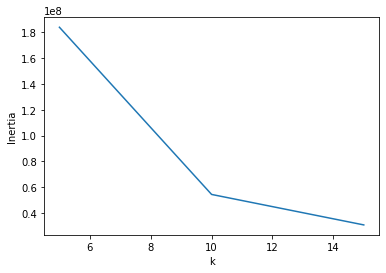

In [31]:
# Plot the inertia over the k values
inertias = [clusterer['kmeans'].inertia_ for clusterer in ks_clusterers]
 
plt.figure()
plt.plot(ks, inertias)
plt.xlabel('k')
plt.ylabel('Inertia')

In [32]:
# Closer to 1 is better
silhouettes = [silhouette_score(clusterer.named_steps['preprocessor'].transform(data), clusterer.predict(data)) for clusterer in ks_clusterers]
silhouettes

[0.9641235440997931, 0.741551271711791, 0.6548983922905942]

 a lower number of clusters produces better results

Gaussian Mixtures
---------

In [63]:
copy['AREA']=SimpleImputer(strategy="median").fit_transform(copy[['AREA']])
y_viz = [int(val) for val in copy["AREA"]]

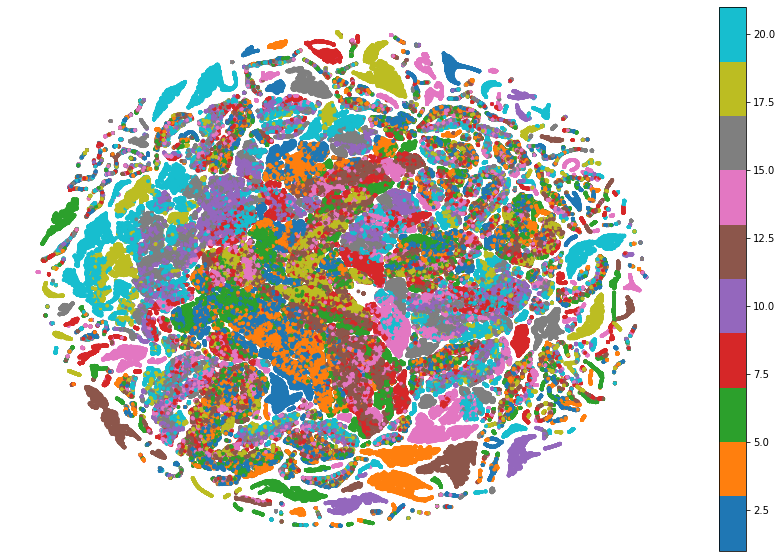

In [64]:
# TSNE, what the hell is this
viz = TSNE(n_components=2, random_state=42, learning_rate='auto', init='random', n_jobs=-1).fit_transform(processed_data)
plt.figure(figsize=(15,10))
plt.scatter(viz[:, 0], viz[:, 1],c =y_viz, cmap='tab10', s=8)
plt.axis('off')
plt.colorbar()

Fine-Tuning
-------

In [68]:
for cluster in ks_clusterers:
    print(cluster.)

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('0 to nan',
                                  convert_values_to_nan_Transformer(feature1='LON',
                                                                    feature2='LAT')),
                                 ('column_transformer',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('drop',
                                                                   'drop',
                                                                   ['DR_NO',
                                                                    'Part 1-2',
                                                                    'Crm Cd 4',
                                                                    'Weapon '
                                                                    'Used Cd',
                          

In [76]:
# For testing out CrimeScore
for cluster in ks_clusterers:
    print(area_populations.get(cluster)
    # score = crime_scorer(data, 'Crm Cd', cluster.fit_predict(data))
    # score



None
None
None


In [ ]:
preprocessor.get_params().keys()

In [ ]:
params = [
     {'kmeans_clusterer__n_clusters' : range(3, 20, 5)}
]

In [ ]:
search = GridSearchCV(preprocessor, params, scoring=CrimeScore(data, "Crm Cd"), cv=3, n_jobs=-1)
search.fit(data)